In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold

from torch.utils.data import DataLoader
import torch

from helpers.data_generation.file_management import read_hdf5
from helpers.data_generation.error_generation_chi2 import Residual, CombineDataset
from helpers.model.helpers_model import NeuralNet

import warnings
warnings.filterwarnings('ignore') 

In [5]:
ratio = 0.75
percent = np.array([0.005, 0.015, 0.005])
size = 6000

batch_size = 50
max_epoch = 150

opti_name = np.array(['SGD/momentum', 'Adam', 'SGD'])



res = Residual()
res.build(size, ratio = ratio, per_error = percent)

str_ID =  "S"+str(size)+"R"+str(int(ratio*100))
[final_array, metadata] = read_hdf5(str_ID)
metadata ['ID'] = np.arange(0,final_array.shape[0])

----------------------------------------------------------------------------------
Finished Training- Normalized: SGD/momentum - epoch: 57.000 - auc: 0.945 

----------------------------------------------------------------------------------
Finished Training- Normalized: Adam - epoch: 22.000 - auc: 0.950 

----------------------------------------------------------------------------------
Finished Training- Normalized: SGD - epoch: 146.000 - auc: 0.935 

----------------------------------------------------------------------------------
Finished Training- Not normalized: SGD/momentum - epoch: 124.000 - auc: 0.946 

----------------------------------------------------------------------------------
Finished Training- Not normalized: Adam - epoch: 91.000 - auc: 0.939 

----------------------------------------------------------------------------------
Finished Training- Not normalized: SGD - epoch: 143.000 - auc: 0.934 



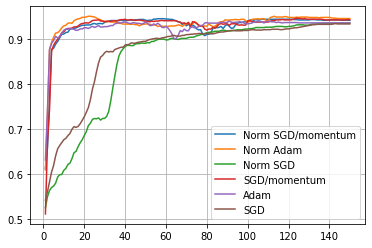

In [3]:
plt.figure()
for norm in np.array([True, False]):
    data_set = CombineDataset(metadata,'ID','class',final_array,norm)

    data_train, data_test = train_test_split(data_set,train_size=0.9,random_state=42)


    loader_train = DataLoader(data_train, batch_size = batch_size, 
                            num_workers = 0, drop_last=True)

    loader_test = DataLoader(data_test, batch_size = batch_size, 
                            num_workers = 0, drop_last=True)


    for opti in opti_name:
        print('----------------------------------------------------------------------------------')

        test_SGDnorm = np.zeros(max_epoch)
        netbasic = NeuralNet('BasicCNN', opti)
        for epoch in range(max_epoch):
            netbasic.train(loader_train)
            res = netbasic.test(loader_test, verbose = False)
            test_SGDnorm[epoch] = res
        
        if norm:
            txt = "Finished Training- Normalized: "+ opti +" - epoch: {:.3f} - auc: {:.3f} \n" 
            print(txt.format(np.argmax(netbasic.epoch_metric)+1, netbasic.max_met))
            plt.plot(np.arange(1, max_epoch+1), test_SGDnorm, label='Norm '+opti)
        else:
            txt = "Finished Training- Not normalized: "+ opti +" - epoch: {:.3f} - auc: {:.3f} \n" 
            print(txt.format(np.argmax(netbasic.epoch_metric)+1, netbasic.max_met))
            plt.plot(np.arange(1, max_epoch+1), test_SGDnorm, label=opti)
plt.legend()
plt.grid()
plt.savefig('figures/baseline/optimizers.jpeg')
plt.show()

In [6]:
metadata ['ID'] = np.arange(0,final_array.shape[0])

data_set = CombineDataset(metadata,'ID','class',final_array)

k_folds = 5 
kfold = KFold(n_splits = k_folds, shuffle = True)


for norm in np.array([True, False]):
    max_AUC = []
    data_set = CombineDataset(metadata,'ID','class',final_array, norm)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(data_set)):
        print(f'FOLD {fold}')
        print('----------------------')

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        loader_train = DataLoader(data_set, batch_size = batch_size, sampler = train_subsampler)
        loader_test = DataLoader(data_set, batch_size = batch_size, sampler = test_subsampler)
    
        for opti in opti_name:
            print('----------------------------------------------------------------------------------')

            netbasic = NeuralNet('BasicCNN', opti)
            while netbasic.current_epoch < max_epoch:
                netbasic.train(loader_train)
                res = netbasic.test(loader_test, verbose = False)
            max_AUC.append(netbasic.max_met)

            if norm:
                txt = "Finished Training- Normalized: "+ opti +" - auc: {:.3f} \n" 
                print(txt.format(mean(max_AUC)))
            else:
                txt = "Finished Training- Not normalized: "+ opti +" - auc: {:.3f} \n" 
                print(txt.format(mean(max_AUC)))

FOLD 0
----------------------
----------------------------------------------------------------------------------


NameError: name 'mean' is not defined